### I implemented the MovileNet v2 based on the original paper using Pytorch. Below is the brief overview about the Hardware, Software and the Model that I used in this work. In the following Section, I will show the code and discuss the step by step approach that I did from data preprocessing, training, and performance profiling. 

## The Hardware and Software Specifications that was used for this work are the following:

### Hardware

* **CPU**: Intel(R) Core(TM) i7-8700K CPU @ 3.70GHz, 3696 Mhz, 6 Core(s), 12 Logical Processor(s)
* **GPU**: NVIDIA GTX2080 TI 11Gb OC
* **RAM**: 32Gb

### Programming Software

* **Operating System**: Windows 10
* **Environment**: Anaconda
* **Language**: Python 3.6
* **GPU Interface**: CUDA 10.1
* **NN Framework**: Pytorch

## The details about the neural network model and the dataset that was used are the following:

### Model

* **Model Name**: MobileNetv2 
* **Paper Source: [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)

### Hyperparameters

* **Loss Funcion**: Cross Entropy Loss 
* **Optimizer**: Stochastic Gradient Descent
* **Learning Rate**: 0.5
* **Momentum**: 0.98
* **Weight Decay**: 0.000004

### Dataset

* **Dataset**: CIFAR10
* **Number of Class**: 10
* **Training Size**: 50000
* **Validation Size**: 10000



## Importing Packages 

#### The first step is to import the packages that I need for the overall work to implement and profile the model. Here, I mainly imorted packages from **torch** or **pytorch** and also numpy for some matrix manipularions and matplotlib for visualisation. Lastly, I imported the class of the MobileNetv2 that I defined from a separate python script.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.optim.lr_scheduler as scheduler
import torch.autograd.profiler as profiler
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from MobileNetv2 import MobileNetv2

## CUDA Platform

### Pytorch has a built in function to select which device to use for training and/or inference calculations. It can be GPU and CPU. In this work, I used GPU accesed through cuda.

In [2]:
"""Load Cuda """
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
""""""""""""""""""

''

## Data Preparation

### In this part, first I defined the data augmentations that I want for every batch of images that will be loaded from the dataset during the training and validation. Data Augmentation will make the dataset more complex and improve the generalization of the model.

### Then using the Pytorch functions, I loaded the dataset and store it in a dataloaded for validation set and training set.

In [3]:

transform = transforms.Compose(
    [
     transforms.RandomRotation(5),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=1000,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valLoader = torch.utils.data.DataLoader(valset, batch_size=1000,
                                         shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### Below I defined a utility function for displaying the images and then I take 4 images from the training set to show how the images look and thre data augmentation that was applied then I printed the corresponding label for each image.

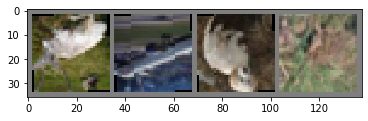

 deer plane   dog  frog


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainLoader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Loading the Model

### Here, I loaded the model for MobileNet v2 that will trained for 10 classes. 
### Afterwards I shown the Summary of the over all model.  You can see at the end that the Total Parameter size is only 2M and is relatively small compared to other state of the art models. This what makes MobileNet v2 lightweight and can be used for Mobile applicatins.

In [5]:
if __name__ == '__main__':

    model = MobileNetv2(num_classes=10)
    model.to(device)
    summary(model, (3,32,32))
   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
          Dropout-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 96, 16, 16]           1,536
      BatchNorm2d-12           [-1, 96, 16, 16]             192
            ReLU6-13           [-1, 96, 16, 16]               0
           Conv2d-14             [-1, 9

### Now, I defined the Loss function and Optimizer that I will use in training the model. The hyperparameters that are used are briefly discussed above.
### I will train the model for 150 epochs because I am expecting that for a simple 10 class classification, my model is still big enough and might cause underfitting when I trained for shorter epochs. 
### You can notice that the learning rate that I have used is relatively large, it is to make my model learn faster and to avoid overfitting I used a momentum and scheduler to reduce the learning rate every defined number of steps.

In [6]:
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.98, weight_decay=0.00004)

    epochs    = 150
    stepLr    = scheduler.StepLR(optimizer,step_size=150, gamma = 0.98)

    train_losses     = []
    train_accuracies = []   
    
    val_losses       = []
    val_accuracies = []

## Training

### I divided the training into two phases, for Training and for Validation. The Validation will run after every epoch, this way I can record the performance of the model for each epoch using unseen data. I am also printing the information such us the current epoch, step, phase, loss, and accuracy so that I can monitor what is happening during the training.


In [7]:
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        for phase in ["train", "valid"]:
            if "train" == phase:
                model.train()
                for step, batch in enumerate(trainLoader):
                    images, labels = batch
                    images, labels = images.to(device), labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled("train" == phase):
                        preds = model(images)
                        
                        loss  = criterion(preds, labels)

                        preds = torch.argmax(preds, dim = 1)
                        acc   = (preds == labels).float().mean()

                        loss.backward()
                        optimizer.step()

                        train_losses.append(loss.item())
                        train_accuracies.append(acc.item())
                        print("Epoch: {0}\t Step: {1}\t Phase: {2}\t Loss: {3:.3f}\t Acc: {4:.3f}".format(epoch,step,phase,loss.item(),acc.item()))
            elif "valid" == phase:
                model.eval()
                for step, batch in enumerate(valLoader):
                    images, labels = batch
                    images, labels = images.to(device), labels.to(device)

                    with torch.set_grad_enabled("train" == phase):
                        preds = model(images)
                        loss  = criterion(preds, labels)
                        preds = torch.argmax(preds, dim = 1)
                        acc   = (preds == labels).float().mean()

                        val_losses.append(loss.item())
                        val_accuracies.append(acc.item())

                        print("Epoch: {0}\t Step: {1}\tPhase: {2}\t Loss: {3:.3f}\t Acc: {4:.3f}".format(epoch,step,phase,loss.item(),acc.item()))
            stepLr.step()



cc: 0.841
Epoch: 144	 Step: 24	 Phase: train	 Loss: 0.436	 Acc: 0.853
Epoch: 144	 Step: 25	 Phase: train	 Loss: 0.425	 Acc: 0.838
Epoch: 144	 Step: 26	 Phase: train	 Loss: 0.394	 Acc: 0.861
Epoch: 144	 Step: 27	 Phase: train	 Loss: 0.371	 Acc: 0.861
Epoch: 144	 Step: 28	 Phase: train	 Loss: 0.419	 Acc: 0.841
Epoch: 144	 Step: 29	 Phase: train	 Loss: 0.391	 Acc: 0.869
Epoch: 144	 Step: 30	 Phase: train	 Loss: 0.393	 Acc: 0.871
Epoch: 144	 Step: 31	 Phase: train	 Loss: 0.419	 Acc: 0.846
Epoch: 144	 Step: 32	 Phase: train	 Loss: 0.511	 Acc: 0.828
Epoch: 144	 Step: 33	 Phase: train	 Loss: 0.428	 Acc: 0.840
Epoch: 144	 Step: 34	 Phase: train	 Loss: 0.432	 Acc: 0.848
Epoch: 144	 Step: 35	 Phase: train	 Loss: 0.433	 Acc: 0.856
Epoch: 144	 Step: 36	 Phase: train	 Loss: 0.393	 Acc: 0.854
Epoch: 144	 Step: 37	 Phase: train	 Loss: 0.412	 Acc: 0.849
Epoch: 144	 Step: 38	 Phase: train	 Loss: 0.426	 Acc: 0.848
Epoch: 144	 Step: 39	 Phase: train	 Loss: 0.465	 Acc: 0.845
Epoch: 144	 Step: 40	 Phase: t

### You can see above that the model has reached a 74% Accuracy and 0.799 Loss in the last validation set. These values are fairly acceptable and near in what was discussed in the original paper. 

## Performance Visualization

### Here I plotted accuracy and loss values during the whole training so that I can visualize the Performance in a larger view.
### I separated the plots for the training and validataion. 
### In terms of the Loss, we can clearly see that in the Training the Loss seems to keep decreasing as the training goes longer while in Validation, it looks like the Loss has already converged 1250th step and if we continue for more epoch it will start overfitting because it looks like the trend is going to rise again.  
### In terms of Accuracy, the training accuracy behaves almost the same as the Training Loss that it keeps increasing as the training goes longer. While in the validation it looks like it already convereged at some point around 1250th step. 

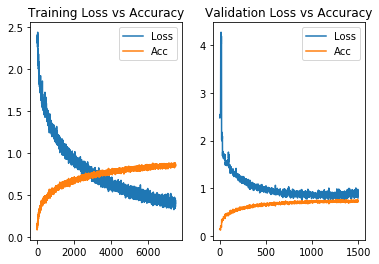

In [8]:
    PATH = './_mobilenetv2_cifar.pth'
    torch.save(model.state_dict(), PATH)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.set_title("Training Loss vs Accuracy")
    ax2.set_title("Validation Loss vs Accuracy")

    ax1.plot(train_losses)
    ax1.plot(train_accuracies)


    ax2.plot(val_losses)
    ax2.plot(val_accuracies)

    ax1.legend(('Loss','Acc'))
    ax2.legend(('Loss','Acc'))
    plt.show()

## Inference

### To test the prediction capability of the model, I saved the trained weights and loaded it for inference.  
### Below shows the input image together with the corresponding groundtruth and the model prediction.
### It is surprising that the model predicted perfectly out of the 4 images but, this is doubtful.

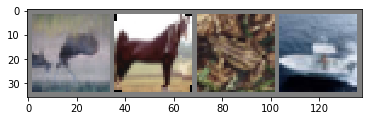

GroundTruth:   deer horse  frog  ship
Predicted:   deer horse  frog  ship


In [9]:
    model = MobileNetv2(num_classes=10)
    model.to(device)

    model.load_state_dict(torch.load("_mobilenetv2_cifar.pth"))
    dataiter = iter(valLoader)
    images, labels = dataiter.next()

    imshow(torchvision.utils.make_grid(images[:4]))

    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]for j in range(4)))

## Validation Performance

### In order to have a larger overview of how weel the model performed on the unseen images from the validation set, I loaded the model again together with the validation set and then I inferenced all the images to get the overall percentage of the prediction accuracy.

### The result is quiet good that it performed 72% accurate in the validation set.

In [10]:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valLoader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


## CPU and GPU Profiling

### In this part, I used another functionality from Pytorch to profile the model execution time and memory consumption.
### The following are the steps that I made:

In [7]:
import torch
import torch.autograd.profiler as profiler
from MobileNetv2 import MobileNetv2 

### First, I reloaded the model and the cuda then I prepared a random dummy input.

In [35]:
"""Load Cuda """
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
""""""""""""""""""
    
model = MobileNetv2(num_classes=10)
model.to(device)

inputs = torch.rand((5,3,256,256),requires_grad = True).to(device)


### Then I used the Profiler whle doing an inference so that it can record the execution time and memory consumptions during the process.

### The Profiler will both record the inference on CPU and GPU

In [51]:
with profiler.profile(record_shapes=True,use_cuda = True) as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

In [53]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                                  Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
------------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
model_inference                       24.32%           12.641ms         99.96%           51.963ms         51.963ms         32.61%           52.053ms         52.053ms         1                
batch_norm                            3.79%            1.969ms          34.53%           17.951ms         345.219us        13.06%           20.850ms         400.952us        52               
_batch_norm_impl_index                1

### Above, I printed the first 10 rows of the profile just to have an overview. 
### We may notice that the CPU performed faster than the CUDA/GPU, one reason is the overhead time it takes to load the CUDA kernels. However, if we looked on how much computing power % the model consumed, the GPU only used 32.61% than the CPU that used almost 100% of its computing power. Therefore, it is still best to use GPU especially for a large models and inorder to minimize the overhead of loading the kernels the programmer might write is code directly using the CUDA libraries so that he can customize it and avoid unecessary workloads and blocking functions.